# 2 - Autoencoder

In [6]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from livelossplot import PlotLossesKeras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint

### Load VGG16 embeddings

In [8]:
im_vecs = pd.read_pickle('../data/image_vecs_vgg16.pkl')
im_vecs

,image_features,item_id
0,"[0.0, 0.0, 0.0, 1.210973, 0.0, 0.0, 2.1445055,...",433
1,"[0.0, 0.88430643, 0.51349455, 0.0, 0.0, 7.3472...",175
2,"[0.0, 0.0, 1.5304266, 0.29221326, 0.0, 0.0, 0....",510
3,"[0.14858103, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",27
4,"[0.0, 0.0, 1.5763377, 0.0, 0.0, 5.456106, 0.0,...",793
...,...,...
1231,"[1.8058506, 4.474393, 0.0, 0.0, 0.18054026, 0....",252
1232,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.34754306, 0.0, 0.0...",727
1233,"[3.2949443, 0.9603162, 0.0, 0.0, 0.0, 0.0, 0.0...",365
1234,"[0.0, 0.0, 0.16038784, 0.0, 0.0, 3.285229, 0.0...",611


### Train basic autoencoder

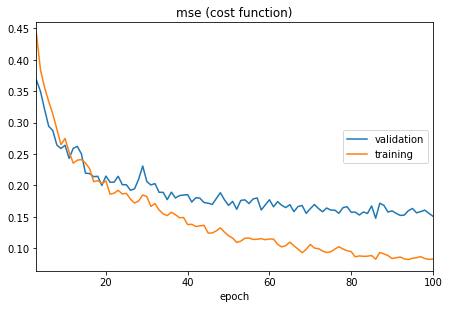

mse (cost function):
validation (min:    0.148, max:    0.626, cur:    0.151)
training   (min:    0.082, max:    0.901, cur:    0.083)
760/760 [==============================] - 0s 532us/sample - loss: 0.0829 - val_loss: 0.1511


In [4]:
im_vec_len = 4096
encoding_dim = 256

im_input=Input(shape=(im_vec_len,), name="Image-Input")
x = GaussianNoise(stddev=0.1)(im_input)
x = Dense(1056, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(528, activation='relu')(x)
encoded = Dense(encoding_dim, activation='relu')(x)
y = Dense(528, activation='relu')(encoded)
y = Dropout(0.2)(x)
y = Dense(1056, activation='relu')(y)
decoded = Dense(im_vec_len, activation='linear')(y)
autoencoder = Model(im_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

best = ModelCheckpoint('../models/ae.h5',
                        monitor='val_loss',
                        verbose=0,
                        save_best_only=True,
                        mode='auto')

autoencoder.fit(np.vstack(im_vecs.image_features), np.vstack(im_vecs.image_features),
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                callbacks=[PlotLossesKeras(),best])

### Encode image features

In [5]:
encoder = Model(im_input, encoded)
encoded_ims = encoder.predict(np.vstack(im_vecs.image_features))

In [ ]:
im_vecs['image_features_encoded'] = pd.Series(encoded_ims.tolist()).to_frame()

In [9]:
im_vecs.to_pickle('../data/image_vecs_encoded.pkl')
encoder.save('../models/encoder.h5')

## Convolutional Autoencoder - experimentation

In [ ]:
filenames = glob.glob('../data/metadata/images/*jpg')
image_size = (256,256)
im_data = []
for i, filename in enumerate(filenames):
    try:
        img = image.load_img(filename, target_size=image_size)
        x = image.img_to_array(img)/255.
        im_data.append(x)
    except:
        continue
im_data = np.array(im_data)


In [108]:
input_img = Input(shape=(256, 256, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [65]:
autoencoder.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 8)         0  

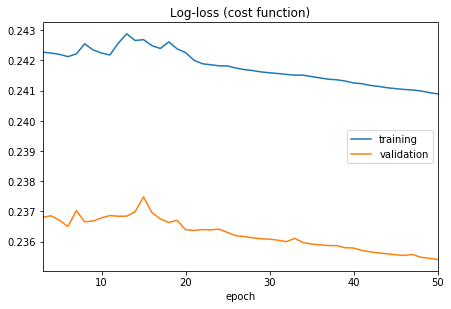

Log-loss (cost function):
training   (min:    0.241, max:    0.243, cur:    0.241)
validation (min:    0.235, max:    0.237, cur:    0.235)
978/978 [==============================] - 5s 5ms/sample - loss: 0.2409 - val_loss: 0.2354


In [129]:
best = ModelCheckpoint('../models/cae.h5',
                        monitor='val_loss',
                        verbose=0,
                        save_best_only=True,
                        mode='auto',
                        period=1)

autoencoder.fit(im_data, im_data,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,
                callbacks=[best, PlotLossesKeras()])

In [130]:
x_test = im_data
decoded_imgs = autoencoder.predict(x_test)
decoded_imgs.shape

(1223, 256, 256, 3)

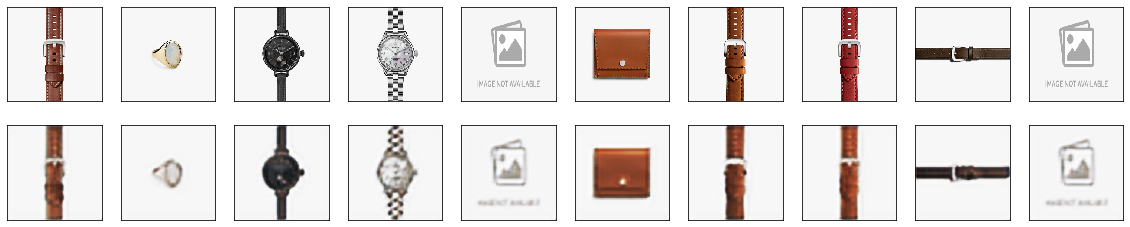

In [131]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(256, 256, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(256, 256, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()